# Orca Classification

In this jupyter notebook I will present the ideas that I used to classify **orca calls**. It includes data pre-processing and a Convolutional Neural Network implementation. At the end of the notebook I will also present some ideas that can be used to further improve our model. 

So, let's get started

## Downloads

### Training Details:
This kaggle kernel has details of the model I trained and in outputs section you can download trained model: https://www.kaggle.com/sainimohit23/myorcanb/output

### Audio Data:
Download the following audio data to prepare training dataset: https://drive.google.com/open?id=1wSJ4qoYZjOat3A9cE_py-HqRSRa5WMlV

## 1 Data preprocessing

Let us first import some packages

In [3]:
from skimage import exposure
import numpy as np
from pydub import AudioSegment
import os
from td_utils import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.misc import imread
import matplotlib.ticker as plticker
from matplotlib import mlab, cm
import shutil
# %matplotlib inline

C:\Users\Babban\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


First I will create two dictionaries which we will be using in our program.

* `labelDict` - maps positive audio to it's label class.
* `label_to_num` - maps every label to a number.

In [2]:
labelDict = {"0": "weeya",
	"1": "weeya",
	"2": "weeya",
	"3": "weeya",
	"4": "weeya",
	"5": "a",
	"6": "updownup",
	"7": "richochet",
	"8": "richochet",
	"9": "richochet",
	"10": "a",
	"11": "c",
	"12": "b",
	"13": "weeya",
	"14": "updownup",
	"15": "updownup",
	"16": "updownup",
	"17": "swoop",
	"18": "updownup"
}

label_to_num = {}
for i,val in enumerate(set(labelDict.values())):
    label_to_num[val] = i
    
label_to_num["negative"] = len(label_to_num)
label_to_num

{'a': 1,
 'b': 3,
 'c': 4,
 'negative': 7,
 'richochet': 6,
 'swoop': 2,
 'updownup': 0,
 'weeya': 5}

### Prepare Backgrounds

Let us first prepare 1 second backgrounds from available data.

In [3]:
#Prepare BGS
def get_random_time_segment_for_BG(high, length):
    length = length*1000
    segment_start = np.random.randint(low=0, high=high-length)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + length
    
    return (segment_start, segment_end)


for file in os.listdir("./backgrounds/"):
    if file.endswith(".wav"):
        bg = AudioSegment.from_wav("./backgrounds/"+file)
        segment_start, segment_end = get_random_time_segment_for_BG(len(bg), 1)
        bg = bg[segment_start:segment_end]
#         print(len(bg))
        if not os.path.exists("./finalData/backgrounds/"):
            os.makedirs("./finalData/backgrounds/")
        bg.export("./finalData/backgrounds/"+file, format='wav')

Now let's define some functions which we will be using to prepare our dataset

In [8]:
def graph_spectrogram(wav_file):
    """Generates and returns a spectrogram for a wav file. Right now upto 2 input channels are supported."""
    rate, data = wavfile.read(wav_file)
    fig,ax = plt.subplots(1)
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    ax.axis('off')
    plt.set_cmap('magma')
    nchannels = data.ndim
    if nchannels ==1:
        pxx, freqs, bins, im = ax.specgram(x=data, Fs=2000, noverlap=192, NFFT=256)
    if nchannels ==2:
        pxx, freqs, bins, im = ax.specgram(x=data[:,0], Fs=100, noverlap=192, NFFT=256)
    ax.axis('off')
    return pxx, freqs, bins

In [5]:
def get_random_time_segment(high, length):
    """Returns a tuple of time segment of length-'length'. 
    Here length < high.
    
    returns:
    a tuple containing
    segment_start - start time of segment
    segment_end - end time of segment"""
    
    segment_start = np.random.randint(low=0, high=high-length)   # Make sure segment doesn't run past the high 
    segment_end = segment_start + length
    
    return (segment_start, segment_end)

In [6]:
def insert_audio_clip(background, audio_clip):
    """Overlays audio clip to the background at random time segment.
    
    returns:
    new_background - final audio clip
    segment_time - tuple of time segment"""
    segment_ms = len(audio_clip)
    segment_time = get_random_time_segment(len(background), segment_ms)
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

In [7]:
def plot_spectrogram(ax, P, name):
    """Saves the spectrogram as image.
    args:
    ax- axis
    P- spectrogram
    name- path & name of image to be saved"""
    
    plt.imshow(P, origin='lower', extent=[-6,6,-1,1], aspect=4, cmap = 'gray')
    ax.axis('off')
    plt.savefig(name+'.jpg', dpi=80)

This is the part where we apply most of the transformations to our images. Transformations include:

### 1. Contrast enhancement
Since the amplitude of the spectrogram is a relative measure, extreme values make the spectrogram lose detail (the image only highlights those extreme values).

To enhance the contrast and appreciate more detail in the spectrogram, the winner submission caps the value in the spectrogram to μ ± 1.5 · σ

This makes a huge difference in the aspect of the spectrogram.

### 2. Removing Local Mean
By using two windows, a large and a small one, we can subtract the local mean of each point. The purpose here is to increase the differences within the shape of the whale call in the spectrogram.

**Functions: `process_horizontal()` and `process_vertical` applies the following two transformations to our images. So, this way we will get two copies of our spectrogram**

### 3. Histogram equilization
We will apply histogram equilization to increase contrast in our images. This is done using skimage's following function `exposure.equalize_hist(PH, nbins = 1000)`.

### 4. Focus on the low frequency spectrum
Since Orca calls generally resides in low frequency spectrum. So, we will only focus on that.


### 5. Merging Images
In fourth step we will merge the images that we got after applying transformations vertically and horizontally.


**The image below summarizes all of the transformation we will be using**

<img src="images/diagram.jpg">

In [8]:
# Applies transformations horizontally
def process_horizontal(PH):
    inner=3
    outer=32
    maxM=60
    QH = PH.copy()
    m, n = QH.shape

    mval, sval = np.mean(QH[:maxM,:]), np.std(QH[:maxM,:])
    fact_ = 3
    QH[QH > mval + fact_*sval] = mval + fact_*sval
    QH[QH < mval - fact_*sval] = mval - fact_*sval
    wInner = np.ones(inner)
    wOuter = np.ones(outer)
    for i in range(maxM):
        QH[i,:] = QH[i,:] - (np.convolve(QH[i,:],wOuter,'same') - np.convolve(QH[i,:],wInner,'same'))/(outer - inner)
    
    return QH

# Applies transformations vertically
def process_vertical(PV):
    inner=3
    outer=64
    maxM=40
    QV = PV.copy()
    m, n = QV.shape

    mval, sval = np.mean(QV[:maxM,:]), np.std(QV[:maxM,:])
    fact_ = 3
    QV[QV > mval + fact_*sval] = mval + fact_*sval
    QV[QV < mval - fact_*sval] = mval - fact_*sval


    wInner = np.ones(inner)
    wOuter = np.ones(outer)
    for i in range(n):
        QV[:,i] = QV[:,i] - (np.convolve(QV[:,i],wOuter,'same') - np.convolve(QV[:,i],wInner,'same'))/(outer - inner)
    return QV


In [9]:
# Overlays one image on top of another
def mergeImg(im, masked, name):
    fig3,ax3 = plt.subplots(1)
    ax3.imshow(im, 'gray', interpolation='none')
    ax3.imshow(masked, 'jet', interpolation='none', alpha=0.3)
    ax3.axis('off')
    fig3.subplots_adjust(left=0,right=1,bottom=0,top=1)
    
    plt.savefig(name+'.jpg', dpi=80)

## Negative data
Now let's create some negative data. First I we have to load the path of all the negative and background audio data.

In [10]:
files = []
for file in os.listdir("./negativeTesting/"):
    if file.endswith(".wav"):
        files.append(file)
        
bgs = []
for file in os.listdir("./finalData/backgrounds/"):
    if file.endswith(".wav"):
        bgs.append(file)

The following code performs the following tasks.

1. Loads a negative file randomly.

    1.1. If length of file is more than 1 sec. Then it selects random 1 sec segment from it. 
    
    1.2. If length is less than 1 sec. Then is overlays the negative sample file on a randomly selected 1 sec background file.
    
2. After processing the length of our sample the transformations described above are applied to the spectrogram of audio file.

3. After all the preprocessing the data is saved in two formats.

    3.1. All the generated images are saved in jpg format.
    3.2. Generated Data is also saved in two  `.npy` files.
        3.2.1 `labels.npy`- Labels.
        3.2.2 `images.npy`- image data.


In [11]:
num_samples = 40
neg_train_labels = np.zeros((num_samples))
neg_train_img_array = np.zeros((num_samples, 320, 480, 3))

if not os.path.exists("./newData/audio/negative"):
        os.makedirs("./newData/audio/negative")
if not os.path.exists("./newData/images/negative"):
        os.makedirs("./newData/images/negative")
for n in range(num_samples):
    file = files[np.random.randint(0, len(files))]
    audio = AudioSegment.from_wav("./negativeTesting/"+file)
#     print("selected Neg for "+str(n)+ ":" + "./negativeTesting/"+file)
    neg_train_labels[n] = int(label_to_num["negative"])
    if len(audio) >= 1000:
        if len(audio) != 1000:
            segment_start, segment_end = get_random_time_segment(len(audio), 1000)
            audio = audio[segment_start:segment_end]
            audio.export("./newData/audio/negative/"+str(n)+".wav", format='wav')
        else:
            audio.export("./newData/audio/negative/"+str(n)+".wav", format='wav')
    else:
        random_BG_file = bgs[np.random.randint(0, len(bgs))]
        background = AudioSegment.from_wav("./finalData/backgrounds/"+random_BG_file)
        background = background
        audio, _ = insert_audio_clip(background, audio)
        audio.export("./newData/audio/negative/"+str(n)+".wav", format='wav')
        
    if not os.path.exists("./newData/images/intermediateData/"):
        os.makedirs("./newData/images/intermediateData/")
    
    P, freqs, bins = graph_spectrogram("./newData/audio/negative/"+str(n)+".wav")
    PH = process_horizontal(P)
    PH = exposure.equalize_hist(PH, nbins = 1000)
    fig1,ax1 = plt.subplots(1)
    fig1.subplots_adjust(left=0,right=1,bottom=0,top=1)
    plot_spectrogram(ax1, PH, './newData/images/intermediateData/L'+str(n))
    PV = process_vertical(P)
    PV = exposure.equalize_hist(PV, nbins = 1000)
    fig2,ax2 = plt.subplots(1)
    fig2.subplots_adjust(left=0,right=1,bottom=0,top=1)
    plot_spectrogram(ax2, PV, './newData/images/intermediateData/R'+str(n))
    
    im1 = imread('./newData/images/intermediateData/R'+str(n)+'.jpg')
    im2 = imread('./newData/images/intermediateData/L'+str(n)+'.jpg')
    
    im1[:165,:] = 255
    im2[:165,:] = 255
    
    mergeImg(im1, im2, './newData/images/negative/'+str(n))
    neg_train_img_array[n] = imread("./newData/images/negative/"+str(n)+".jpg")

shutil.rmtree("./newData/images/intermediateData/")

C:\Users\Babban\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\Babban\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\Babban\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:50: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\Babban\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitl

In [12]:
from keras.utils import to_categorical
neg_train_encoded = to_categorical(neg_train_labels, num_classes=8)
np.save("./newData/audio/negative/labels.npy", neg_train_encoded)
np.save("./newData/audio/negative/images.npy", neg_train_img_array)

Using TensorFlow backend.


## Positive data
First I want to show what spectrograms generated from my RNN model(model that detects time of orca calls) looks like. All these spectrograms have 1 sec length.

<img src="images/0.jpg"><img src="images/1.jpg">

<img src="images/2.jpg">


So, to get similar training data I will perform 3 types of data augmentation. All the spectrogram transformations described above will be applied in all of the three cases.

* First I will generate data similar to what I did for negative data.This way we will be able to generate data like picture 3 above.


* Secondly, I will crop positive audio to an extent where it will contain only orca call( audio length less than 1 sec). This way I will be able to generate positive data where orca calls will be overlayed on random background time segments.


* Third, in third type of positive data orca calls will be cropped 20%-30% either from beggining or end. Then these will be overlayed either starting or end of the randomly selected background. This way we will be able to generate data like pictures 1 and 2 above.


Let's load path of positive data and generate first type of positive Data. First type of data will look something like these.

<img src="images/33.jpg"><img src="images/34.jpg"><img src="images/44.jpg">

In [13]:
files = []
for file in os.listdir("./positive/"):
    if file.endswith(".wav"):
        files.append(file)
        
bgs = []
for file in os.listdir("./finalData/backgrounds/"):
    if file.endswith(".wav"):
        bgs.append(file)

In [14]:
import numpy as np
num_samples = 300
s = num_samples//3
positive_train_labels = np.zeros((num_samples))
positive_train_img_array = np.zeros((num_samples, 320, 480, 3))

if not os.path.exists("./newData/audio/positive"):
        os.makedirs("./newData/audio/positive")
if not os.path.exists("./newData/images/positive"):
        os.makedirs("./newData/images/positive")

for n in range(0, s):
    randNum = np.random.randint(0, len(files))
    file = files[randNum]
    positive_train_labels[n] = int(label_to_num[labelDict[str(randNum)]])
    audio = AudioSegment.from_wav("./positive/"+file)
    audio +=20
    if len(audio) >= 1000:
        if len(audio) != 1000:
            segment_start, segment_end = get_random_time_segment(len(audio), 1000)
            audio = audio[segment_start:segment_end]
            audio.export("./newData/audio/positive/"+str(n)+".wav", format='wav')
        else:
            audio.export("./newData/audio/positive/"+str(n)+".wav", format='wav')
    else:
        random_BG_file = bgs[np.random.randint(0, len(bgs))]
        background = AudioSegment.from_wav("./finalData/backgrounds/"+random_BG_file)
        background = background
        audio, _ = insert_audio_clip(background, audio)
        audio.export("./newData/audio/positive/"+str(n)+".wav", format='wav')
    if not os.path.exists("./newData/images/intermediateData/"):
        os.makedirs("./newData/images/intermediateData/")
    
    P, freqs, bins = graph_spectrogram("./newData/audio/positive/"+str(n)+".wav")
    PH = process_horizontal(P)
    PH = exposure.equalize_hist(PH, nbins = 1000)
    fig1,ax1 = plt.subplots(1)
    fig1.subplots_adjust(left=0,right=1,bottom=0,top=1)
    plot_spectrogram(ax1, PH, './newData/images/intermediateData/L'+str(n))
    PV = process_vertical(P)
    PV = exposure.equalize_hist(PV, nbins = 1000)
    fig2,ax2 = plt.subplots(1)
    fig2.subplots_adjust(left=0,right=1,bottom=0,top=1)
    plot_spectrogram(ax2, PV, './newData/images/intermediateData/R'+str(n))
    
    im1 = imread('./newData/images/intermediateData/R'+str(n)+'.jpg')
    im2 = imread('./newData/images/intermediateData/L'+str(n)+'.jpg')
    
    im1[:165,:] = 255
    im2[:165,:] = 255
    
    mergeImg(im1, im2, './newData/images/positive/'+str(n))
    positive_train_img_array[n] = imread("./newData/images/positive/"+str(n)+".jpg")

shutil.rmtree("./newData/images/intermediateData/")

C:\Users\Babban\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\Babban\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:46: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\Babban\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:47: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\Babban\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5

**Now lets create Second type of positive data. For this let's load path of super short positive orca calls**. Examples:
<img src="images/165.jpg"><img src="images/157.jpg">

In [15]:
"""smolpositive contains highly trimmed positive audio data"""
files = []
for file in os.listdir("./smolpositive/"):
    if file.endswith(".wav"):
        files.append(file)
        
bgs = []
for file in os.listdir("./finalData/backgrounds/"):
    if file.endswith(".wav"):
        bgs.append(file)

In [16]:
import numpy as np
import math

for n in range(s, s*2):
    randNum = np.random.randint(0, len(files))
    file = files[randNum]
    positive_train_labels[n] = int(label_to_num[labelDict[str(randNum)]])
    audio = AudioSegment.from_wav("./smolpositive/"+file)
    audio +=20
    if len(audio) >= 1000:
        if len(audio) != 1000:
            segment_start, segment_end = get_random_time_segment(len(audio), 1000)
            audio = audio[segment_start:segment_end]
            audio.export("./newData/audio/positive/"+str(n)+".wav", format='wav')
        else:
            audio.export("./newData/audio/positive/"+str(n)+".wav", format='wav')
    else:
        random_BG_file = bgs[np.random.randint(0, len(bgs))]
        background = AudioSegment.from_wav("./finalData/backgrounds/"+random_BG_file)
#         background = background - 20
        if len(audio) >850:
            b = math.floor(np.random.uniform(0, 0.3)*len(audio))
            st = np.random.randint(0, b)
            audio = audio[st:]

        audio, _ = insert_audio_clip(background, audio)
        audio.export("./newData/audio/positive/"+str(n)+".wav", format='wav')
    if not os.path.exists("./newData/images/intermediateData/"):
        os.makedirs("./newData/images/intermediateData/")
    
    P, freqs, bins = graph_spectrogram("./newData/audio/positive/"+str(n)+".wav")
    PH = process_horizontal(P)
    PH = exposure.equalize_hist(PH, nbins = 1000)
    fig1,ax1 = plt.subplots(1)
    fig1.subplots_adjust(left=0,right=1,bottom=0,top=1)
    plot_spectrogram(ax1, PH, './newData/images/intermediateData/L'+str(n))
    PV = process_vertical(P)
    PV = exposure.equalize_hist(PV, nbins = 1000)
    fig2,ax2 = plt.subplots(1)
    fig2.subplots_adjust(left=0,right=1,bottom=0,top=1)
    plot_spectrogram(ax2, PV, './newData/images/intermediateData/R'+str(n))
    
    im1 = imread('./newData/images/intermediateData/R'+str(n)+'.jpg')
    im2 = imread('./newData/images/intermediateData/L'+str(n)+'.jpg')
    
    im1[:165,:] = 255
    im2[:165,:] = 255
    
    mergeImg(im1, im2, './newData/images/positive/'+str(n))
    positive_train_img_array[n] = imread("./newData/images/positive/"+str(n)+".jpg")

shutil.rmtree("./newData/images/intermediateData/")

C:\Users\Babban\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\Babban\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\Babban\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\Babban\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5

**For third type of positive data we have to re-define `insert_audio_clip()` function first.** EX-
<img src="images/231.jpg"><img src="images/242.jpg">

In [17]:
import random
random.choice([True, False])
def insert_audio_clip2(background, audio_clip):
    segment_ms = len(audio_clip)
    c = random.choice([True, False])
    if c == True:
        pos = 0
    else:
        pos = len(background) - len(audio_clip)
    new_background = background.overlay(audio_clip, position=pos)
    return new_background, None

In [18]:
import numpy as np
import math

for n in range(s*2, s*3):
    randNum = np.random.randint(0, len(files))
    file = files[randNum]
    positive_train_labels[n] = int(label_to_num[labelDict[str(randNum)]])
    audio = AudioSegment.from_wav("./smolpositive/"+file)
    audio +=20
    if len(audio) >= 1000:
        if len(audio) != 1000:
            segment_start, segment_end = get_random_time_segment(len(audio), 1000)
            audio = audio[segment_start:segment_end]
            audio.export("./newData/audio/positive/"+str(n)+".wav", format='wav')
        else:
            audio.export("./newData/audio/positive/"+str(n)+".wav", format='wav')
    else:
        random_BG_file = bgs[np.random.randint(0, len(bgs))]
        background = AudioSegment.from_wav("./finalData/backgrounds/"+random_BG_file)
#         background = background - 20
        if len(audio) >850:
            b = math.floor(np.random.uniform(0, 0.3)*len(audio))
            if b != 0:
                st = np.random.randint(0, b)
            else:
                st = b
            audio = audio[st:]

        audio, _ = insert_audio_clip2(background, audio)
        audio.export("./newData/audio/positive/"+str(n)+".wav", format='wav')
    if not os.path.exists("./newData/images/intermediateData/"):
        os.makedirs("./newData/images/intermediateData/")
    
    P, freqs, bins = graph_spectrogram("./newData/audio/positive/"+str(n)+".wav")
    PH = process_horizontal(P)
    PH = exposure.equalize_hist(PH, nbins = 1000)
    fig1,ax1 = plt.subplots(1)
    fig1.subplots_adjust(left=0,right=1,bottom=0,top=1)
    plot_spectrogram(ax1, PH, './newData/images/intermediateData/L'+str(n))
    PV = process_vertical(P)
    PV = exposure.equalize_hist(PV, nbins = 1000)
    fig2,ax2 = plt.subplots(1)
    fig2.subplots_adjust(left=0,right=1,bottom=0,top=1)
    plot_spectrogram(ax2, PV, './newData/images/intermediateData/R'+str(n))
    
    im1 = imread('./newData/images/intermediateData/R'+str(n)+'.jpg')
    im2 = imread('./newData/images/intermediateData/L'+str(n)+'.jpg')
    
    im1[:165,:] = 255
    im2[:165,:] = 255
    
    mergeImg(im1, im2, './newData/images/positive/'+str(n))
    positive_train_img_array[n] = imread("./newData/images/positive/"+str(n)+".jpg")

shutil.rmtree("./newData/images/intermediateData/")

C:\Users\Babban\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\Babban\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:46: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\Babban\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:47: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\Babban\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5

In [19]:
# Saves all types of positive data in same directory
from keras.utils import to_categorical
positive_train_encoded = to_categorical(positive_train_labels, num_classes=8)
np.save("./newData/audio/positive/labels.npy", positive_train_encoded)
np.save("./newData/audio/positive/images.npy", positive_train_img_array)

# Building and training model

Since data is very small. It is not enough to train heavy models of the size of vgg, resnet or inception. So, I built a model with two convolutional layers and three dense layers. Model quickly got accuracy around 100%. Data wasn't enough to test accuracy on validation and test set.

I would recommend you to look at [this kaggle kernal](https://www.kaggle.com/sainimohit23/myorcanb) for more information about training of model.

Now let's import packages and start building our model.

In [20]:
import numpy as np
import keras
import os
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.models import load_model
import time
%matplotlib inline

In [22]:
# Load data
X_train = np.append(np.load("newData/audio/positive/images.npy"), np.load("newData/audio/negative/images.npy"), axis=0)
Y_train = np.append(np.load("newData/audio/positive/labels.npy"), np.load("newData/audio/negative/labels.npy"), axis=0)

**Preprocess image data.**

In [ ]:
for i in range(X_train.shape[0]):
    X_train[i] = (X_train[i]/255)
    X_train[i] = X_train[i] -  0.5
    X_train[i] = 2*X_train[i]

In [ ]:
num=11
plt.imshow(X_train[num])
print(Y_train[num])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 0. 0. 0. 0. 1. 0. 0.]


**Build the model**

In [ ]:
inp = keras.layers.Input(shape=(320, 480, 3))
X = keras.layers.Conv2D(32, (2, 2), activation='relu', padding='same')(inp)
X = keras.layers.Conv2D(48, (2, 2), activation='relu', padding='same')(X)
X = keras.layers.MaxPool2D()(X)
X = keras.layers.Dropout(0.5)(X)
X = keras.layers.Flatten()(X)
X = keras.layers.Dense(128, activation='relu')(X)
X = keras.layers.Dropout(0.3)(X)
X = keras.layers.Dense(64, activation='relu')(X)
X = keras.layers.Dropout(0.4)(X)
X = keras.layers.Dense(8, activation='softmax')(X)

model = keras.models.Model(inp, X)
# c = ModelCheckpoint("../input/model.h5", monitor='train_loss')
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-3, decay=1e-6, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

In [ ]:
model.fit(x=X_train, y= Y_train, batch_size=8, epochs=1, shuffle=True)

In [ ]:
# model.save("./model.h5")

# Other techniques that can be used for Data Augmentation.
Now I will show some other techniques which we can use for data augmentation. I didn't applied these techniques on the data above because of the size of the available data. Right now dataset is so small that it is impossible to know which of these techniques will help our model to learn. Right now, no matter what techniques we use on our data, our model will eventually attain almost $100$% accuracy.

## 1. Dropout bursts
Dropout bursts are created by selecting time instants uniformly at random and setting the signal values in a 50ms vicinity of those time instants to zero. Dropout burst therefore model short periods of weak signal.

## 2. Random Resampling

In [4]:
# Data augmentation scheme: Dropout bursts
def zero_filter(input, threshold=2, depth=8):
    shape = input.shape
    # compensate for lost length due to mask processing
    noise_shape = [shape[0], shape[1] + depth]
    
    # Generate random noise
    noise = np.random.normal(0,1,noise_shape)
    
    # Pick positions where the noise is above a certain threshold
    mask = np.greater(noise, threshold)
    
    # grow a neighbourhood of True values with at least length depth+1
    for d in range(depth):
        mask = np.logical_or(mask[:, :-1], mask[:, 1:])
    output = np.where(mask, np.zeros(shape), input)
    return output

# Data augmentation scheme: Random resampling
def random_resample(signals, upscale_factor = 1):
    [n_signals,length] = signals.shape
    new_length = np.random.randint(
        low=int(length*80/120),
        high=int(length*80/60),
        size=[n_signals, upscale_factor])
    signals = [np.array(s) for s in signals.tolist()]
    new_length = [np.array(nl) for nl in new_length.tolist()]
    sigs = [stretch_squeeze(s,l) for s,nl in zip(signals,new_length) for l in nl]
    sigs = [fit_tolength(s, length) for s in sigs]
    sigs = np.array(sigs)
    return sigs


# Helper functions needed for data augmentation
def stretch_squeeze(source, length):
    target = np.zeros([1, length])
    interpol_obj = sc.interpolate.interp1d(np.arange(source.size), source)
    grid = np.linspace(0, source.size - 1, target.size)
    result = interpol_obj(grid)
    return result

def fit_tolength(source, length):
    target = np.zeros([length])
    w_l = min(source.size, target.size)
    target[0:w_l] = source[0:w_l]
    return target

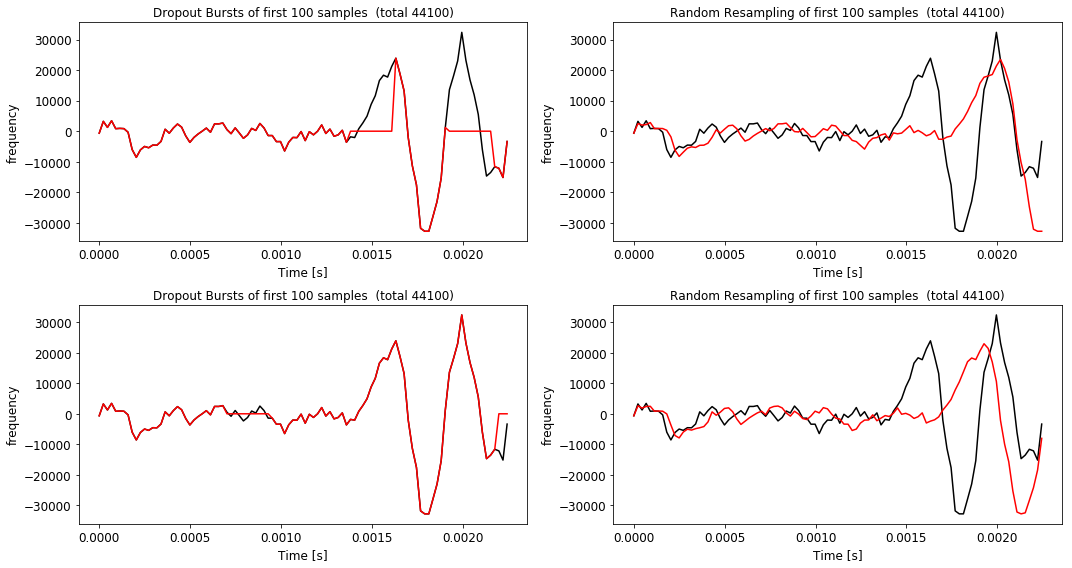

In [5]:
import scipy as sc
rate, ts_extended = wavfile.read("12.wav")
data_zero = [] # collect the zero burst data here
data_resampled = [] # list for resampled data
runs = 2

time = np.arange(0, len(ts_extended))/rate

for i in range(runs):
    data_zero.append(zero_filter(np.expand_dims(ts_extended, axis = 0), threshold = 2, depth = 10)[0])
    data_resampled.append(random_resample(np.expand_dims(ts_extended, axis = 0))[0])

# Plot the result
fig, axarr = plt.subplots(runs, 2, figsize = (15, 8))
x_label = 'Time [s]'
y_label = 'frequency'

for row in range(runs):
    
    # Plot the dropout burst data
    ax = axarr[row, 0]
    ax.plot(time[:100], ts_extended[:100], 'k')
    ax.plot(time[:100], data_zero[row][:100], 'r')

    ax.set(xlabel = x_label, ylabel = y_label)
    ax.set_title("Dropout Bursts of first 100 samples  (total 44100)")
    
    
    
    # Plot the resampling data
    ax = axarr[row, 1]
    ax.plot(time[:100], ts_extended[:100], 'k')
    ax.plot(time[:100], data_resampled[row][:100], 'r')

    ax.set(xlabel = x_label, ylabel = y_label)
    ax.set_title("Random Resampling of first 100 samples  (total 44100)")
    
for ax in np.ndarray.flatten(axarr):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)

plt.tight_layout()
# plt.suptitle('Data augmentation: dropout bursts and random resampling', fontsize = 15)
plt.show()
# fig.savefig('augmentation.png', bbox_inches = 'tight', dpi = 150)

## 3. Wiener filter to reduce the noise

In [6]:
def plot_side_by_side(P,Q,title1):
    fig = plt.figure(figsize = (14,4))
    ax1 = plt.subplot(121)
    plot_spectrogram(ax1, P)
    ax2 = plt.subplot(122)
    plot_spectrogram(ax2, Q)
    plt.suptitle(title1, fontsize = 16)
    plt.show()
    
def plot_spectrogram(ax, P):
    plt.imshow(P, origin='lower', extent=[-6,6,-1,1], aspect=4, cmap = cm.get_cmap('bwr'))
    loc = plticker.MultipleLocator(base=3.0) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)
    ax.set_xticklabels(np.arange(-0.5,2.5,0.5))
    ax.set_yticklabels(range(0,1001,250))
    ax.set_xlabel('Time (seconds)', fontsize = 12)
    ax.set_ylabel('Frequency (Hz)', fontsize = 12)
    cbar = plt.colorbar()
    cbar.set_label('Amplitude', fontsize = 12)

C:\Users\Babban\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\scipy\signal\signaltools.py:492: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


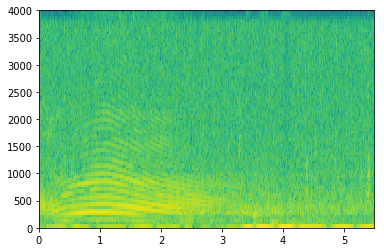

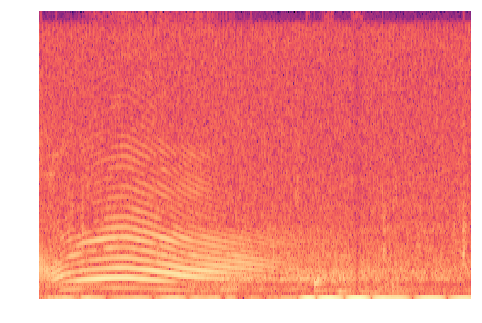

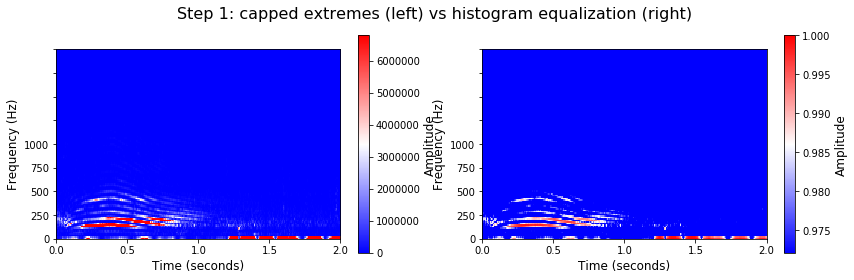

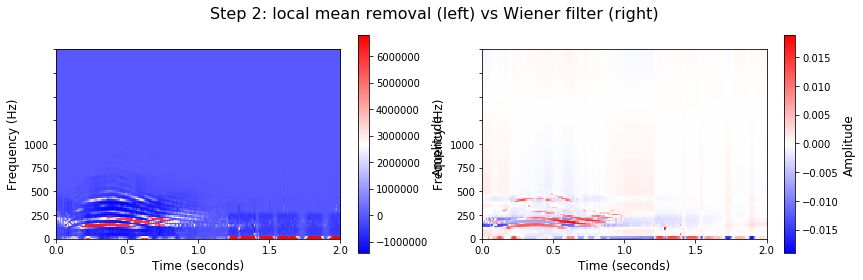

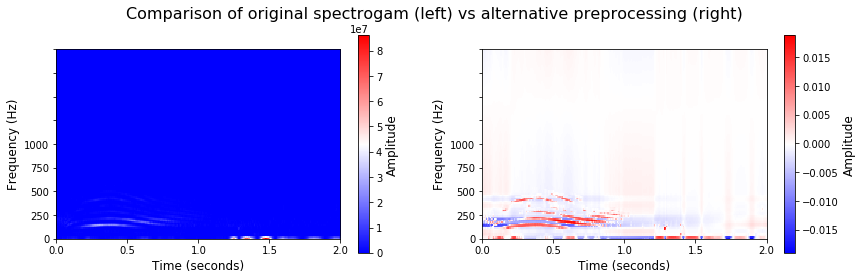

In [9]:
from scipy.signal import wiener, detrend

# Read one (whale) file as an example
params = {'NFFT':256, 'Fs':2000, 'noverlap':192} 
P, freqs, bins = graph_spectrogram("12.wav")

m, n = P.shape
maxM=40
inner=3
outer=32

# Original capping of extreme values (Kaggle winner)
Q = P.copy()
mval, sval = np.mean(Q[:maxM,:]), np.std(Q[:maxM,:])
fact_ = 1.5
Q[Q > mval + fact_*sval] = mval + fact_*sval
Q[Q < mval - fact_*sval] = mval - fact_*sval
    
# Original local mean removal (Kaggle winner)
Q2 = Q.copy()
wInner = np.ones(inner)
wOuter = np.ones(outer)
for i in range(n):
    Q2[:,i] = Q2[:,i] - (np.convolve(Q2[:,i],wOuter,'same') - np.convolve(Q2[:,i],wInner,'same'))/(outer - inner)

# Histogram equalization (alternative)
T4 = exposure.equalize_hist(P, nbins = 65)

T5 = T4.copy()
# Detrend both vertically and horizontally  (alternative)
T5 = detrend(T5, axis = 1)
T5 = detrend(T5, axis = 0)
# Apply a Wiener filter (alternative)
T5 = wiener(T5, 4)

title = 'Step 1: capped extremes (left) vs histogram equalization (right)'
plot_side_by_side(Q, T4, title)
title = 'Step 2: local mean removal (left) vs Wiener filter (right)'
plot_side_by_side(Q2, T5, title)
title = 'Comparison of original spectrogam (left) vs alternative preprocessing (right)'
plot_side_by_side(P, T5, title)